# Classification Performance Measures

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## SGDClassifier
We use the scikit-learn SGDClassifier as a basic example of a classifier, to examine different performance measures. It implements regularised linear models trained via SGD and the default loss is "hinge", in which case the model is linear SVM. We apply this to the task of classification in teh MNIST handwritten digits dataset.

In [2]:
mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Text(0.5, 1.0, 'Target = 5')

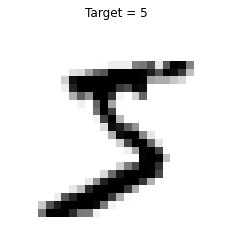

In [4]:
digit_eg = X[0].reshape(28,28)
plt.imshow(digit_eg, cmap = "binary")
plt.axis("off")
plt.title(f"Target = {y[0]}")

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

For simplicity just work with the binary classification task five or not

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
sgd_clf = SGDClassifier(random_state = 50)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=50)

Here are some example predictions

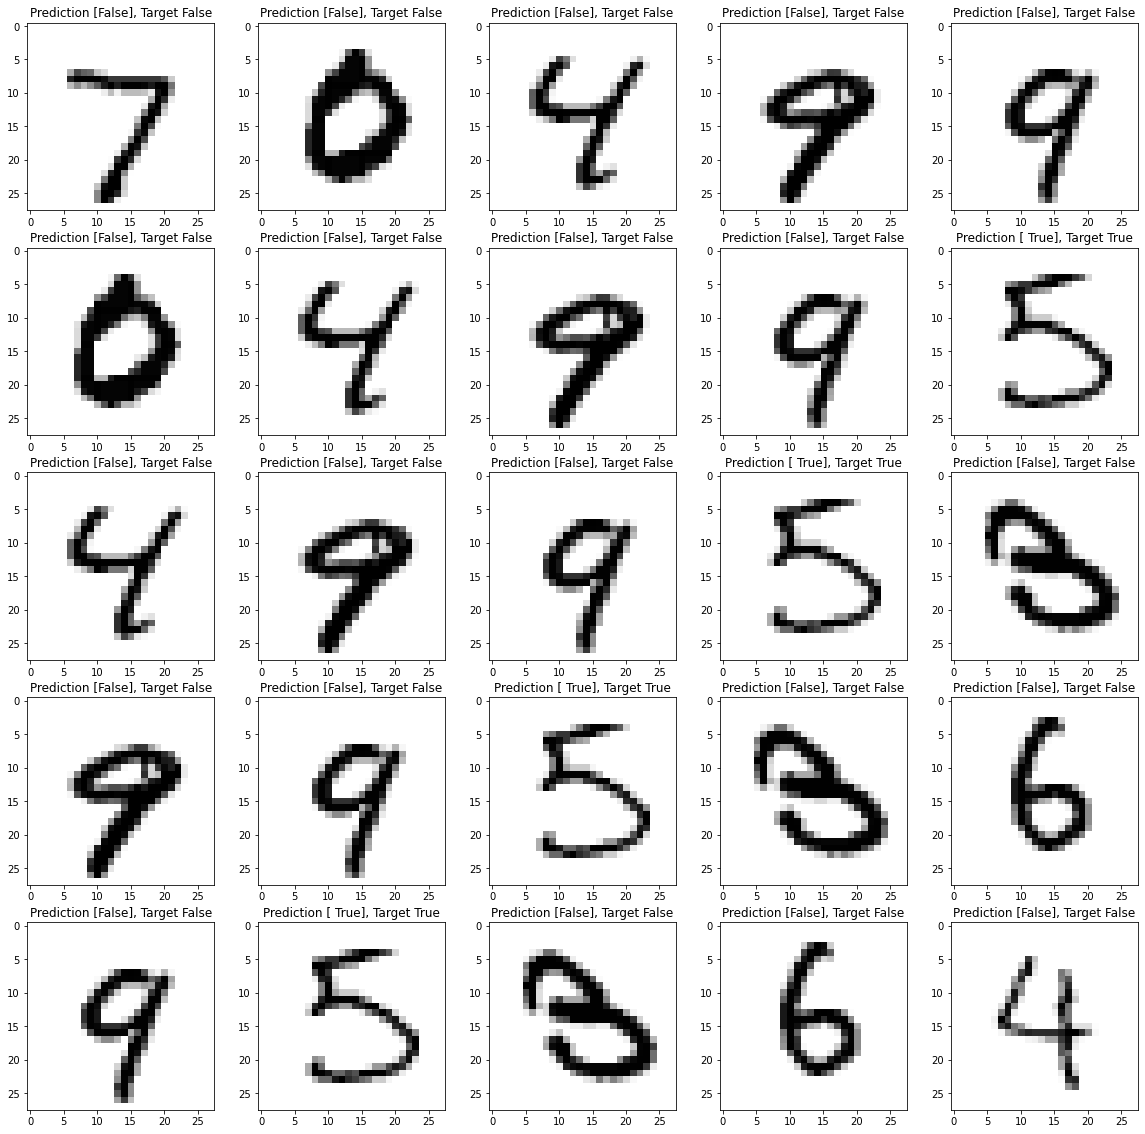

In [8]:
fig, axs = plt.subplots(5,5, figsize = (20,20))
for i in range(5):
    for j in range(5):
        target = y_test_5[3*i + 3*j]
        image = X_test[3*i + 3*j]
        pred = sgd_clf.predict([image])
        axs[i,j].imshow(image.reshape(28,28), cmap = "binary")
        axs[i,j].set_title(f"Prediction {pred}, Target {target}")

## Performance Measures

### Cross-Validation Accuracy

In [9]:
scores = cross_val_score(sgd_clf, X_test, y_test_5, scoring = "accuracy", cv = 5)
np.mean(scores)

0.9531000000000001

Score seems high, but consider the clas imbalance. How well can we do just classifying everything as not 5

In [10]:
unique, counts = np.unique(y_test_5, return_counts=True)
dict(zip(unique, counts))

{False: 9108, True: 892}

In [11]:
class Never5Classifier(BaseEstimator):
    def __init__(self):
        super().__init__()
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

dummy_classifier = Never5Classifier()
scores = cross_val_score(dummy_classifier, X_test, y_test_5, scoring = "accuracy", cv = 5)
np.mean(scores)

0.9108

In this case accuracy is not a great performance measure due to the class imbalance. We will explore other options.

## Confusion Matrix

Here we will be tracking false negatives, false positives, true negatives and true positives. Below we use cross_val_predict to get a prediction for each instance by a model which has not seen it in training.

In [12]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
confusion_matrix(y_train_5, y_train_pred)

array([[53519,  1060],
       [ 1126,  4295]], dtype=int64)

This gives us more complete information than just accuracy, but we might like to have something more concise and objective. Next we look at precision and recall, which also aim to consider false negatives, false positives, true negatives and true positives but in a single number.

## Precision & Recall

$$\text{Precision }= \frac{TP}{TP+FP} = \text{ Fraction of positive predictions (5s) that are correct}$$

$$\text{Recall }= \frac{TP}{TP+FN} = \text{ Fraction of positive instances (5s) that are detected as positive}$$

In [14]:
precision_score(y_train_5, y_train_pred)

0.8020541549953315

In [15]:
recall_score(y_train_5, y_train_pred)

0.7922892455266556

i.e 80% of those claimed as 5 by the classifier are actually 5, while 79% of actual 5s are classified as 5

F1 score is a metric aiming to combine these two metrics. In fact it is the harmonic mean of the two. This mean gives a much higher weight to low values so F1 will only be low if both precision and recall are high.

$$F_1 = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}} = 2\times\frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [16]:
f1_score(y_train_5, y_train_pred)

0.7971417965850038

This metric does favour models where precision and recal are similar, which is not always desired. For example if training a classifier to detect videos as safe for kids, you would probably rather reject good videos (low recall) but accept only good videos (high precision) rather than the reverse where all good videos are accepted but more bad ones are also accepted.

## Decision Function

Ultimately the classifier makes a decision based on comparing some computed value to some threshold. This mapping from input to value is called the decision function. With sklearn models we can not generally adjust the threshold value, but we can access the decision function values and then use any threshold to assign classes.

In [17]:
y_scores = sgd_clf.decision_function([X_train[0]])
y_scores

array([3180.70599554])

In [18]:
threshold = 0 
y_pred = (y_scores > threshold)
y_pred

array([ True])

0 is the threshold of the SGDClassifier

In [19]:
y_train_5[0]

True

We could apply a different threshold easily like below

In [20]:
threshold = 5000
y_pred = (y_scores > threshold)
y_pred

array([False])

Intuitively, raising the threshold means we make it harder for us to classify something as True (5). As a result we improve precision (more of those classified as 5s are 5s) but decrease recall (more actual 5s are missed by the classifier). 

If we want to decide the best threshold we can use cross_val_predict to return the decision function values instead of predictions. Using these with the precision_recall_curve function will show how precision and recall vary as we adjust threshold.

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")
precs, recs, threshs = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precs, recs, threshs):
    plt.plot(threshs, precs[:-1], "b--", label = "Precision")
    plt.plot(threshs, recs[:-1], "r-", label = "Recall")
    plt.legend()
    return

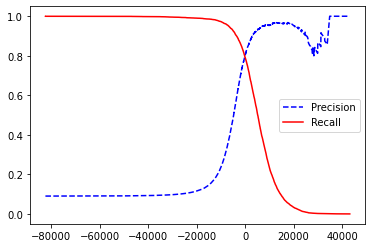

In [22]:
plot_precision_recall_vs_threshold(precs, recs, threshs)

Alternatively we can directly plot precision vs recall.

Text(0, 0.5, 'Precision')

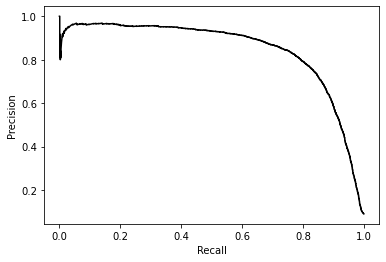

In [23]:
plt.plot(recs, precs, "k-")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Roc Curve

Receiver Operating Characteristic (ROC) curve is another option. This plots True Positive Rate (same as recall) vs False Positive Rate. Equivalently plots recall/sensitivity vs 1-specificity.

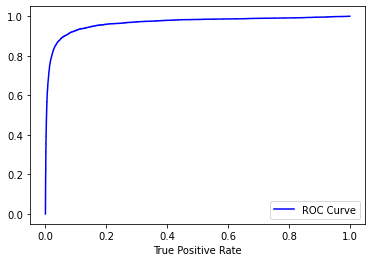

In [24]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plt.plot(fpr,tpr, 'b-', label = "ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()

A way to quantify this is the area under the curve (AUC). A perfect classifier will have AUC 1

In [25]:
roc_auc_score(y_train_5, y_scores)

0.965984097238232

## Multiclass Classification

* One vs Rest (OvR): Train a binary classifier for each class and select the one with the highest score (descision function)
* One vs One (OvO): Train a binary classifier for each pair ($N\times\frac{N-1}{2}$ classifiers) and choose the class that wins the most 

For algorithms which scale poorly, OvO faster with large data as training many on small data vs less on full data. For most OvR is perferred. Scikit-Learn implements these automatically when you try to apply a classifier to a multiclass problem.

In [26]:
svm_clf = SVC()
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([X_test[0]])

array(['7'], dtype=object)

In [27]:
scores = svm_clf.decision_function([X_test[0]])
print(scores)
print(np.argmax(scores))

[[ 2.77898901 -0.28543563  6.09151189  7.15487836  4.84054137  3.92448246
   0.71652165  9.30809074  1.74780902  8.27250042]]
7


If you want to force OvO or OvR:

In [28]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC())

In [29]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X_train[0]])

KeyboardInterrupt: 

## Error Analysis

In [30]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

KeyboardInterrupt: 

In [ ]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

In [ ]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)